# A Notebook to test the track based recog training and eval

In [53]:
# ---- Necessary Imports

import yaml
import os
from glob import glob
import os
import pandas as pd
import json
import pickle
import numpy as np

### Specify Training and Evaluation Files 
This method iterates through a folder of training csvs and evaluates them on the same test (query) file using the same reference file each time. 

In [54]:
#dir containing training csvs to start working with 
train_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_max.csv'
test_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_max.csv'
#test on all of batch 2 (open set) gonna also test on all of batch 1 


results_file = './results_with_tracks_2_imgs.csv'

file_paths = []

## Loop through files, train and eval model

Code may need to be modified for differnt training sets such as
* run_str parsing to include important variables such as num_ids
* the path to your template yml config file
*

In [4]:
#Test Training handle file

wandb_name = os.path.basename(os.path.dirname(train_file)) #set wandb_dir_name

#------------ Initilize and make new dir for each training set-----

# Saves wandb folder, checkpoints, and outputs to folder named based on run string, which should contain attrs that differntiate run
run_str = os.path.basename(train_file)[34:-4] #MAY NEED TO MODIFY BASED ON CSV NAME
run_dir_name = run_str+'/'
if not os.path.exists(run_dir_name):
    os.mkdir(run_dir_name)
split_parts = run_str.rsplit('_', 1) #String parse csv name
if len(split_parts) > 1: # Check if there is at least one underscore in the string
    # Get the substring after the last underscore
    num_images = split_parts[1]
    num_ids = split_parts[0][:2]
else:
    # Handle the case where there are no underscores in the string
    num_images = run_str

##---------- Initilize new config .yml for new training file---------------

#open config yaml to update experiment params
with open('pytorch_train_and_eval_recog.yml', 'r') as fo:
    config = yaml.safe_load(fo)

#Update params
config['model_settings']['num_labels']= num_ids
print('Num labels ',num_ids)

#Check if batch size needs to be updated
df = pd.read_csv(train_file)
if config['data_settings']['batch_size'] > len(df):
    config['data_settings']['batch_size'] = len(df)
    print('Updated batch to contain all Data. Size = ',len(df))

#Check if print_k needs to be updated for small dataset
print_k = config['train_settings']['print_k']
if print_k > len(df)/config['data_settings']['batch_size']:
    print_k = len(df)/config['data_settings']['batch_size']
    config['train_settings']['print_k'] = print_k
    print('Updating print_k to contain whole epoch. Num_batches =',print_k)

#Testing a differnt num of epochs based on loop
config['train_settings']['num_epochs'] = 150
config['train_settings']['percent_pos'] = .5

#updating datafiles
config['data_settings']['datafiles']['train']=train_file
config['data_settings']['datafiles']['test'] = test_file

#update Model path
config['model_settings']['model_path'] = './'+run_dir_name+run_str+'.pth'

#update pickle_file to prevent being overwritten
pickle_file = './'+run_dir_name+'results.pkl'
config['eval_settings']['pickle_file'] = pickle_file
config['eval_settings']['results_file'] = results_file

#update wandb_project_name
config['train_settings']['wandb_project_name'] = 'recog_attention _test'+wandb_name
config['train_settings']['wandb_dir_path'] = run_dir_name #this should make a seperate wandb folder for runs

#save yml
new_yml_file = './'+run_dir_name+run_str+'.yml'
with open(new_yml_file, 'w') as fo:
        yaml.dump(config,fo)   

#---------- actually run training too--------------
!python pytorch_train_and_eval_SCL_track_recog.py --config_file {new_yml_file}

# Save model to wandb file location to prevent overwriting
# new dir in wandb/ will be generated each training run
!cp {config['model_settings']['model_path']} {config['train_settings']['wandb_dir_path']+'/wandb/latest-run/files/'+os.path.basename(config['model_settings']['model_path'])}

# read python results from pickle file, 
with open(config['eval_settings']['pickle_file'],'rb') as fi:
    results = pickle.load(fi)  

# Write out run summary to results tracking document

results_dict =  {'run_str': run_str,
                                    'wandb_id':results['wandb_id'],
                                    'num_ids':num_ids,
                                    'num_images_per_id':num_images,
                                    'total_training_images':len(pd.read_csv(train_file))-(len(pd.read_csv(train_file))*config['data_settings']['percent_valid']),
                                    'batch_size':config['data_settings']['batch_size'],
                                    'num_epochs':config['train_settings']['num_epochs'],
                                    'train_loss':results['train_loss'],
                                    'valid_loss':results['valid_loss'],
                                    '1NN':results['1NN_acc'],
                                    '3NN':results['3NN_acc'],
                                    'training_file':train_file,
                                    'images_per_track':results['images_per_track'],
                                    'total_testing_images':results['total_testing_images'],
                                    'total_refernece_images':results['total_reference_images'],
                                    'start_time':results['start_time'],
                                    'train_time':results['train_time'],
                                    'stop_epoch':results['stop_epoch']}


# results_dict = {'run_str': run_str,
#                                     'wandb_id':results['wandb_id'],
#                                     'num_ids':num_ids,
#                                     'num_images_per_id':num_images,
#                                     'total_training_images':results['train_num'],
#                                     'batch_size':config['data_settings']['batch_size'],
#                                     'num_epochs':config['train_settings']['num_epochs'],
#                                     'train_loss':results['train_loss'],
#                                     'valid_accuracy':results['valid_accuracy'],
#                                     'training_file':train_file,
#                                     'test_file':test_file,
#                                     'accuracy': results['accuracy'],
#                                     'precision':results['precision'],
#                                     'recall':results['recall'],
#                                     'start_time':results['start_time'],
#                                     'train_time':results['train_time'],
#                                     'stop_epoch':results['stop_epoch'],
#                                     'model_class':config['model_settings']['model_class'],
#                                     'embedder_path':config['model_settings']['embeddor_path'],
#                                     'early_stopping_metric':config['train_settings']['early_stopping_metric'],
#                                     'eval_percent_positive':results['eval_positive_prob'],
#                                     'train_percent_positive':results['train_positive_prob'],
#                                     'roc_auc':results['roc_auc']}

#initilize file if nonexisttant or empty 
if not os.path.exists(config['eval_settings']['results_file']):
    !touch {config['eval_settings']['results_file']}
    results_df = pd.DataFrame(results_dict,index=[0])
    results_df.to_csv(config['eval_settings']['results_file'])
else:
    #read df and append row
    results_df = pd.read_csv(config['eval_settings']['results_file'])
    results_df.loc[len(results_df)] = results_dict
    results_df.to_csv(config['eval_settings']['results_file'],index=False)


Num labels  64
2024-04-11 00:05:29.569975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 00:05:30.391278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
finished imports
beginning execution
finished imports
beginning execution
wandb: Currently logged in as: lqmeyers. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.1
wandb: Run data is saved locally in 64_ids_batch1_sample_num_max/wandb/run-20240411_000533-o3i60k5g
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fiery-durian-47
wandb: ⭐️ View project at https://wandb.ai/lqmeyers/rec

In [6]:
### Troubleshooting results writing by manually writing to csv 
# read python results from pickle file, 

with open(config['eval_settings']['pickle_file'],'rb') as fi:
    results = pickle.load(fi)  

print("Reading file", fi)
# Write out run summary to results tracking document
print(results)
results_dict =  {'run_str': run_str,
                                    'wandb_id':results['wandb_id'],
                                    'num_ids':num_ids,
                                    'num_images_per_id':num_images,
                                    'total_training_images':len(pd.read_csv(train_file))-(len(pd.read_csv(train_file))*config['data_settings']['percent_valid']),
                                    'batch_size':config['data_settings']['batch_size'],
                                    'num_epochs':config['train_settings']['num_epochs'],
                                    'train_loss':results['train_loss'],
                                    'valid_loss':results['valid_loss'],
                                    'total_testing_images': results['total_testing_images'],
                                    'total_reference_images': results['total_reference_images'],
                                    '1NN':results['1NN_acc'],
                                    '3NN':results['3NN_acc'],
                                    'training_file':train_file,
                                    'start_time':results['start_time'],
                                    'train_time':results['train_time'],
                                    'stop_epoch':results['stop_epoch']}


# results_dict = {'run_str': run_str,
#                                     'wandb_id':results['wandb_id'],
#                                     'num_ids':num_ids,
#                                     'num_images_per_id':num_images,
#                                     'total_training_images':results['train_num'],
#                                     'batch_size':config['data_settings']['batch_size'],
#                                     'num_epochs':config['train_settings']['num_epochs'],
#                                     'train_loss':results['train_loss'],
#                                     'valid_accuracy':results['valid_accuracy'],
#                                     'training_file':train_file,
#                                     'test_file':test_file,
#                                     'accuracy': results['accuracy'],
#                                     'precision':results['precision'],
#                                     'recall':results['recall'],
#                                     'start_time':results['start_time'],
#                                     'train_time':results['train_time'],
#                                     'stop_epoch':results['stop_epoch'],
#                                     'model_class':config['model_settings']['model_class'],
#                                     'embedder_path':config['model_settings']['embeddor_path'],
#                                     'early_stopping_metric':config['train_settings']['early_stopping_metric'],
#                                     'eval_percent_positive':results['eval_positive_prob'],
#                                     'train_percent_positive':results['train_positive_prob'],
#                                     'roc_auc':results['roc_auc']}

#initilize file if nonexisttant or empty 
if not os.path.exists(config['eval_settings']['results_file']):
    !touch {config['eval_settings']['results_file']}
    results_df = pd.DataFrame(results_dict,index=[0])
    results_df.to_csv(config['eval_settings']['results_file'])
else:
    #read df and append row
    results_df = pd.read_csv(config['eval_settings']['results_file'])
    results_df.loc[len(results_df)] = results_dict
    results_df.to_csv(config['eval_settings']['results_file'],index=False)

Reading file <_io.BufferedReader name='./64_ids_batch1_sample_num_max/results.pkl'>
{'1NN_acc': 0.0678, '3NN_acc': 0.0613, 'label_list': array([ 65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]), 'train_loss': 0.0, 'valid_loss': 0.1021724808961153, 'wandb_id': 'p8exoyqo', 'start_time': 1712727254.605884, 'train_time': 5.3815252661705015, 'stop_epoch': 63}


  1%|          | 2/298 [00:00<01:11,  4.13it/s]100%|██████████| 298/298 [01:02<00:00,  4.79it/s]


Accuracy: 0.95
Precision: 0.92
Recall: 0.99
0.9957727389126741


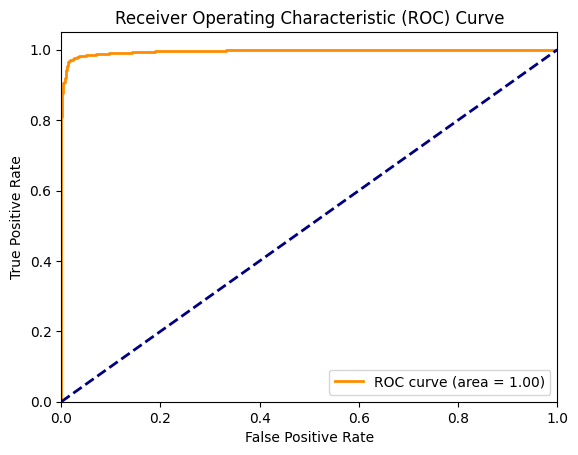

In [7]:
## Code for running seperate evaluation

import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from pytorch_train_and_eval_recognition import Flowerpatch_Pairs, RecogModel
import sys
sys.path.insert(1, '/home/lmeyers/beeid_clean_luke/PYTORCH_CODE/')
sys.path.insert(2, '/home/lmeyers/beeid_clean_luke/KEY_CODE_FILES/')
from data import prepare_for_triplet_loss
import torch.nn as nn 
from tqdm import tqdm


#load embedder and classifier 
emb_path = '/home/gsantiago/ReID_model_training/new_auto_train_eval/models_trained/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64/wandb/run-20231106_004425-yida7voj/files/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth'
model_name = os.path.basename(emb_path)
embedder = torch.load(emb_path) #TODO look into graph mode for pytorch, embeddor being duplicated 
#embedder.eval()

model = RecogModel()
model_dict = torch.load("/home/lmeyers/tranf_recog/64_ids_batch2_sample_num_64/_ids_batch2_sample_num_64.pth")
model.load_state_dict(model_dict)

#Define the cross-entropy loss function
loss_fn = nn.BCEWithLogitsLoss() #More stable, 

image_size = (256,256)
bs = 32

#Test dataloader 
fname = test_file
dft = pd.read_csv(fname)
dft = prepare_for_triplet_loss(dft, 'ID', 'filepath')

# Build test dataset and dataloader
test_dataset = Flowerpatch_Pairs(dft, 'filename', 'label',image_size,'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
embedder.to(device)

#---- perform evaluation

model.eval()

# Forward pass through the classifier
with torch.no_grad():
    test_binary_preds = np.empty((0,))
    test_logits_preds = np.empty((0,))
    test_truth = np.empty((0,))
    for test_batch_idx, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        test_features = data['image']
        test_pairs = data['pair']
        test_labels = data['label'].to(device)

        # get embeddings of img pair
        test_reference = embedder(test_features.to(device))
        test_query = embedder(test_pairs.to(device))
    
        # Pass through model
        test_outputs = model(test_reference,test_query) #calling model vs calling forward (check understanding)
        test_logits = test_outputs.squeeze()

        test_outputs = torch.sigmoid(test_outputs)
        test_outputs = test_outputs.squeeze() #
        
        # Calculate the predicition loss
        test_loss = loss_fn(test_outputs, test_labels)
       
        #____ test outputs (i forgot the word)
        test_outputs = test_outputs.detach().cpu().numpy()
        test_logits = test_logits.detach().cpu().numpy()
        test_outputs = (test_outputs>=0.5).astype(int)

        test_truth = np.concatenate((test_truth, test_labels.detach().cpu().numpy()))
        test_binary_preds = np.concatenate((test_binary_preds,test_outputs)) #TODO fix this one too to prevent truncation
        test_logits_preds = np.concatenate((test_logits_preds,test_logits))

# Convert to PyTorch tensors (if not already)
conf = confusion_matrix(test_truth,test_binary_preds)

accuracy = accuracy_score(test_truth,test_binary_preds)
precision = precision_score(test_truth,test_binary_preds)
recall = recall_score(test_truth,test_binary_preds)
    
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

#calculate roc curve and plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_score are your ground truth labels and predicted scores respectively
fpr, tpr, _ = roc_curve(test_truth,test_logits_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## If folder contains csvs from both batches: run below code

#### In event of run failure to record automatically
Use below code to save run details from results.pickle even if there was an issue in your run

In [5]:

with open(config['eval_settings']['pickle_file'],'rb') as fi:
    results = pickle.load(fi)   

# Write out run summary to results tracking document
results_df = pd.read_csv(config['eval_settings']['results_file'])
results_df.loc[len(results_df)] = {'run_str': run_str,
                                    'wandb_id':results['wandb_id'],
                                    'num_ids':num_ids,
                                    'num_images_per_id':num_images,
                                    'total_training_images':len(pd.read_csv(train_file)),
                                    'batch_size':config['data_settings']['batch_size'],
                                    'num_epochs':config['train_settings']['num_epochs'],
                                    'train_loss':results['train_loss'],
                                    'valid_loss':results['valid_loss'],
                                    '1NN':results['1NN_acc'],
                                    '3NN':results['3NN_acc'],
                                    'training_file':train_file,
                                    'reference_file':reference_file,
                                    'query_file':query_file,
                                    'start_time':results['start_time'],
                                    'train_time':results['train_time'],
                                    'stop_epoch':results['stop_epoch']}
results_df.to_csv(config['eval_settings']['results_file'],index=False)



## Run training cell by cell

In [1]:
##imports 
import torch
import sys
sys.path.insert(1, '/home/lmeyers/beeid_clean_luke/PYTORCH_CODE/')
sys.path.insert(2, '/home/lmeyers/beeid_clean_luke/KEY_CODE_FILES/')
sys.path.insert(3,'/home/lmeyers/paintid')

from pytorch_resnet50_conv3 import resnet50_convstage3
from data import prepare_for_triplet_loss

import numpy as np
import pandas as pd
from PIL import Image as Image2
import matplotlib.pyplot as plt

import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from sklearn.metrics import confusion_matrix
import sys 

import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

2024-04-11 14:23:41.618047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 14:23:42.586103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#initilize filepaths
#dir containing training csvs to start working with 
train_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_max.csv'
test_file = '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_max.csv'
#test on all of batch 2 (open set) gonna also test on all of batch 1 


results_file = './results_with_tracks_seperate_training_test.csv'

file_paths = []

In [5]:
#update config file and wandbdir 

wandb_name = os.path.basename(os.path.dirname(train_file)) #set wandb_dir_name

#------------ Initilize and make new dir for each training set-----

# Saves wandb folder, checkpoints, and outputs to folder named based on run string, which should contain attrs that differntiate run
run_str = os.path.basename(train_file)[34:-4] #MAY NEED TO MODIFY BASED ON CSV NAME
run_dir_name = run_str+'/'
if not os.path.exists(run_dir_name):
    os.mkdir(run_dir_name)
split_parts = run_str.rsplit('_', 1) #String parse csv name
if len(split_parts) > 1: # Check if there is at least one underscore in the string
    # Get the substring after the last underscore
    num_images = split_parts[1]
    num_ids = split_parts[0][:2]
else:
    # Handle the case where there are no underscores in the string
    num_images = run_str

##---------- Initilize new config .yml for new training file---------------

config_file = 'pytorch_train_and_eval_recog.yml'

#open config yaml to update experiment params
with open(config_file, 'r') as fo:
    config = yaml.safe_load(fo)

#Update params
config['model_settings']['num_labels']= num_ids
print('Num labels ',num_ids)

#Check if batch size needs to be updated
df = pd.read_csv(train_file)
if config['data_settings']['batch_size'] > len(df):
    config['data_settings']['batch_size'] = len(df)
    print('Updated batch to contain all Data. Size = ',len(df))

#Check if print_k needs to be updated for small dataset
print_k = config['train_settings']['print_k']
if print_k > len(df)/config['data_settings']['batch_size']:
    print_k = len(df)/config['data_settings']['batch_size']
    config['train_settings']['print_k'] = print_k
    print('Updating print_k to contain whole epoch. Num_batches =',print_k)

#Testing a differnt num of epochs based on loop
config['train_settings']['num_epochs'] = 150
config['train_settings']['percent_pos'] = .5

#updating datafiles
config['data_settings']['datafiles']['train']=train_file
config['data_settings']['datafiles']['test'] = test_file

#update Model path
config['model_settings']['model_path'] = './'+run_dir_name+run_str+'.pth'

#update pickle_file to prevent being overwritten
pickle_file = './'+run_dir_name+'results.pkl'
config['eval_settings']['pickle_file'] = pickle_file
config['eval_settings']['results_file'] = results_file

#update wandb_project_name
config['train_settings']['wandb_project_name'] = 'recog_attention _test'+wandb_name
config['train_settings']['wandb_dir_path'] = run_dir_name #this should make a seperate wandb folder for runs

#save yml
new_yml_file = './'+run_dir_name+run_str+'.yml'
with open(new_yml_file, 'w') as fo:
        yaml.dump(config,fo)   
        print(f"Written to {new_yml_file}")

Num labels  64
Written to ./64_ids_batch1_sample_num_max/64_ids_batch1_sample_num_max.yml


In [6]:
#Open conffig file
config_file = new_yml_file
try:
    with open(config_file) as f:
        config = yaml.safe_load(f)
    model_config = config['model_settings'] # settings for model building
    train_config = config['train_settings'] # settings for model training
    data_config = config['data_settings'] # settings for data loading
    eval_config = config['eval_settings'] # settings for evaluation
    torch_seed = config['torch_seed']
    verbose = config['verbose']
except Exception as e:
    print('ERROR - unable to open experiment config file. Terminating.')
    print('Exception msg:',e)


In [7]:
# DEVICE INFO NEEDED TO KNOW WHERE WE WILL PERFORM COMPUTATIONS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set gpu to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use GPU with index 1

########################## Function for getting embeddings of an entire dataset ##########################

def get_embeddings_w_track(model, dataloader,device):
    model.eval()
    embeddings = []
    labels = []
    tracks = []
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(batch['image'].to(device))
            labels += list(batch['label'].detach().cpu().numpy())
            tracks += list(batch['track'].detach().cpu().numpy())
            embeddings.append(outputs) #keep in tensor format #.detach().cpu().numpy())
    embeddings = torch.vstack(embeddings) #variable stack? 
    labels = np.array(labels)
    tracks = np.array(tracks)
    return embeddings, labels, tracks


In [8]:
from torch.utils.data import Dataset, DataLoader
## Define Dataset for precomputing embeddings, ideally filter dataset first before doing embeddings

##################################################################################################
# Flowerpatch Dataset Class that also includes track labels, in order to precompute 
# embeddings but maintain track distinctions
###################################################################################################

class Flowerpatch_w_Track_and_Filter(Dataset):
    def __init__(self, df, fname_col, label_col, track_col, image_size, split, imgs_per_track=5, aug_p = 0.3):
        super(Flowerpatch_w_Track_and_Filter, self).__init__()
        self.df = df
        self.fname_col = fname_col # column containing file name or path
        self.label_col = label_col # column containing label/ID
        self.image_size = image_size # image size, for Resize transform
        self.track_col = track_col #column containing track information
        self.imgs_per_track = imgs_per_track
        self.split = split # specifies dataset split (i.e., train vs valid vs test vs ref vs query)
        self.aug_p = aug_p # prob to apply data augmentation methods
        self.transform = transforms.Compose([transforms.Resize(image_size),
                                             transforms.ToTensor(),
                                            ])
        augmentation_methods = transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(degrees=(0, 2*np.pi)), 
                                                                  transforms.ColorJitter(brightness=0.5, contrast=0.5)]), p=aug_p)
        self.train_transform = transforms.Compose([augmentation_methods,
                                                    transforms.Resize(image_size),
                                                    transforms.ToTensor()]) # include here augmentation techniques
        
        print("Full:",len(self.df))
        #  filter df to only contain long enough tracks
        self.df = self.df.groupby([self.track_col,self.label_col]).filter(lambda x: len(x) > self.imgs_per_track)
        print("With enough imgs per track:",len(self.df))
        #  remove id with only 1 track
        self.df = self.df.groupby(self.label_col).filter(lambda x: len(np.unique(x[self.track_col])) > 1)
        print("With only ids with multiple filtered tracks:",len(self.df))
        self.df_len = len(df)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_label = self.df.iloc[idx][self.label_col]
        id_label = torch.tensor(id_label, dtype=torch.long)
        track_label = self.df.iloc[idx][self.track_col]
        track_label = torch.tensor(track_label, dtype=torch.long)
        img_path = self.df.iloc[idx][self.fname_col]
        image = Image2.open(img_path)
        # add transforms with data augmentation if train set
        if self.split == 'train':
            image = self.train_transform(image)
        else:
            image = self.transform(image)
        return {'image':image, 'label':id_label,'track':track_label}
###################################################################################################



In [9]:
## Compute Embeddings
image_size = [256,256]

emb_path = model_config['embeddor_path']
model_name = os.path.basename(emb_path)

#Load embeddor and get embeddings
model_name = os.path.basename(emb_path)
embedder = torch.load(emb_path)
embedder.eval() 

## Define Dataloaders for training of aggregator, including subsampling validation set if necessary

image_size = data_config['input_size']
bs = data_config['batch_size']
num_epochs = train_config['num_epochs']

train_pos_prob = train_config['percent_pos']

if data_config['datafiles']['valid'] != None: 
    df = pd.read_csv(data_config['datafiles']['train'])
    print("Reading dataframe at ",data_config['datafiles']['train'])
    train_dataset = Flowerpatch_w_Track_and_Filter(df,'new_filepath','ID','track',image_size,'train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    train_embeddings, train_labels, train_tracks = get_embeddings_w_track(embedder,train_dataloader,device)
    print('Train embeddings made with',model_name,"shape:",train_embeddings.size())


    ### Valid dataset and dataloader
    valid_df = pd.read_csv(data_config['datafiles']['valid'])
    #valid_df = prepare_for_triplet_loss(valid_df, data_config['label_col'], data_config['fname_col']) #deprecated function standardizes col names

    valid_dataset = Flowerpatch_w_Track_and_Filter(valid_df,'new_filepath','ID','track',image_size,'test')
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False)
    valid_embeddings, valid_labels, valid_tracks = get_embeddings_w_track(embedder,valid_dataloader)
    print('Valid embeddings made with',model_name,"shape:",valid_embeddings.size())

else:
    print("Generating Train validation split")
    #if no valid dataset, sample from training set
    print("Reading dataframe at ",data_config['datafiles']['train'])
    train_df = pd.read_csv(data_config['datafiles']['train'])
    print(train_df.columns)

    valid_num_rows = round(data_config['percent_valid']*len(train_df))
    valid_rows = train_df.sample(n=valid_num_rows)
    
    train_df = train_df.drop(valid_rows.index)
    train_num = len(train_df)
    valid_df = valid_rows

    print(f"Using {valid_num_rows} samples for validation set")
    print(f"{train_num} total training samples")

    #train_df = prepare_for_triplet_loss(train_df, data_config['label_col'], data_config['fname_col']) #deprecated function only renames columns

    train_dataset = Flowerpatch_w_Track_and_Filter(train_df,'new_filepath','ID','track',image_size,'train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    train_embeddings, train_labels, train_tracks = get_embeddings_w_track(embedder,train_dataloader,device)
    print('Train embeddings made with',model_name,"shape:",train_embeddings.size())


    valid_dataset = Flowerpatch_w_Track_and_Filter(valid_df,'new_filepath','ID','track',image_size,'test')
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False)
    valid_embeddings, valid_labels, valid_tracks = get_embeddings_w_track(embedder,valid_dataloader,device)
    print('Valid embeddings made with',model_name,"shape:",valid_embeddings.size())


# # BUILD DATASET AND DATALOADER
# dataset = Flowerpatch_w_Track_and_Filter(df,'new_filepath','ID','track',image_size,'test')
# bs=32
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False)
# train_embeddings, train_labels, train_tracks = get_embeddings_w_track(embedder,dataloader)
# print('Train embeddings made with',model_name,"shape:",train_embeddings.size())


Generating Train validation split
Reading dataframe at  /home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_max.csv
Index(['Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'img_number', 'ID',
       'color_id', 'frame', 'track', 'batch', 'pass', 'environment',
       'bee_range', 'filepath', 'background', 'reID', 'color_num',
       'new_filepath'],
      dtype='object')
Using 2053 samples for validation set
8211 total training samples
Full: 8211
With enough imgs per track: 7736
With only ids with multiple filtered tracks: 7725
Train embeddings made with summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth shape: torch.Size([7725, 128])
Full: 2053
With enough imgs per track: 1121
With only ids with multiple filtered tracks: 979
Valid embeddings made with summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth shape: torch.Size

In [13]:
##perform quick KNN to test quality of embeddings 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
######################################################################################
# FUNCTION TO PERFORM KNN EVALUATION
#
def knn_evaluation(train_images, train_labels, test_images, test_labels, n_neighbors, per_class=True, conf_matrix=True):
    # BUILD KNN MODEL AND PREDICT
    results = {}
    print(f"Training kNN classifier with k=1")
    my_knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    my_knn.fit(train_images, train_labels)
    knn_pred = my_knn.predict(test_images)
    knn_acc = np.round(np.sum([1 for pred, label in zip(knn_pred, test_labels) if pred == label])/test_labels.shape[0],4)
    print(f"1NN test accuracy: {knn_acc}")
    # store results
    results['1NN_acc'] = knn_acc

    print(f"Training kNN classifier with k=3")
    my_knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
    my_knn.fit(train_images, train_labels)
    knn_pred = my_knn.predict(test_images)
    knn_acc = np.round(np.sum([1 for pred, label in zip(knn_pred, test_labels) if pred == label])/test_labels.shape[0],4)
    print(f'3NN test accuracy: {knn_acc}')
    # store results
    results['3NN_acc'] = knn_acc

    label_list = np.unique(train_labels)
    results['label_list'] = label_list
    if per_class:
        knn_class = np.zeros(len(label_list))
        print(f'\nPer label {n_neighbors}NN test accuracy:')
        for k, label in enumerate(label_list):
            mask = test_labels == label
            knn_class[k] = np.round(np.sum(knn_pred[mask]==test_labels[mask])/np.sum(mask),4)
            print(f'{label}\t{knn_class[k]:.2f}')
        # store results
        results['knn_class'] = knn_class
    if conf_matrix:
        knn_conf = confusion_matrix(test_labels, knn_pred)
        results['knn_conf'] = knn_conf
        print('\nPrinting Confusion Matrix:')
        print(results['knn_conf'])
    return results
#########################################################################################

naive = knn_evaluation(valid_embeddings.cpu().numpy(),valid_labels,train_embeddings.cpu().numpy(),train_labels,1,False,False)

Training kNN classifier with k=1
1NN test accuracy: 0.6791
Training kNN classifier with k=3
3NN test accuracy: 0.6791


In [48]:
### Build test dataloader and subsample for reference set

test_df = pd.read_csv(data_config['datafiles']['test'])
print(len(test_df))
# Step 1: Group by 'ID' and 'Track' and filter out tracks with fewer than 10 images
grouped = test_df.groupby(['ID', 'track']).filter(lambda x: len(x) >= 10)
print(len(grouped))

# Step 2: Select a random track with at least 10 images for each 'ID'
random_tracks = grouped.groupby('ID')['track'].apply(lambda x: np.random.choice(x)).reset_index()


idx = 0
for i, row in random_tracks.iterrows():
    id = row['ID']
    track = row['track']
    id_to_check = test_df[test_df['ID']==id]
    to_check = id_to_check[id_to_check['track'] == track]
    selected_images = to_check.sample(n=5)
    if idx == 0:
        ref_df = selected_images
    else:
        ref_df = pd.concat([ref_df,selected_images],axis=0)
    idx+=1 


# Step 5: Remove sampled images from the source DataFrame
test_df = test_df.drop(ref_df.index)

from pytorch_data import Flowerpatch_w_Track

test_num = len(test_df)
ref_num_rows = len(ref_df)

print(f"Using {ref_num_rows} samples for validation set")
print(f"{test_num} total test samples")

#train_df = prepare_for_triplet_loss(train_df, data_config['label_col'], data_config['fname_col']) #deprecated function only renames columns

test_dataset = Flowerpatch_w_Track_and_Filter(test_df,'new_filepath','ID','track',image_size,'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
test_embeddings, test_labels, test_tracks = get_embeddings_w_track(embedder,test_dataloader,device)
print('Test embeddings made with',model_name,"shape:",test_embeddings.size())


ref_df.head()
ref_dataset = Flowerpatch_w_Track(ref_df,'new_filepath','ID','track',image_size,'test')
ref_dataloader = torch.utils.data.DataLoader(ref_dataset, batch_size=bs, shuffle=False)
ref_embeddings, ref_labels, ref_tracks = get_embeddings_w_track(embedder,ref_dataloader,device)
print('Reference embeddings made with',model_name,"shape:",ref_embeddings.size())
    

10866
10468
Using 315 samples for validation set
10551 total test samples
Full: 10551
With enough imgs per track: 10347
With only ids with multiple filtered tracks: 10340
Test embeddings made with summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth shape: torch.Size([10340, 128])
Reference embeddings made with summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth shape: torch.Size([315, 128])


In [14]:
print("KNN within test embeddings (initilized on ref set:)")
naive1 = knn_evaluation(ref_embeddings.cpu().numpy(),ref_labels,test_embeddings.cpu().numpy(),test_labels,1,False,False)
print("")

KNN within test embeddings (initilized on ref set:)
Training kNN classifier with k=1
1NN test accuracy: 0.8133
Training kNN classifier with k=3
3NN test accuracy: 0.7968



In [15]:
print('Embedding tensor array size',train_embeddings.size())
print('Embedding track and ID labels', train_tracks.shape)


Embedding tensor array size torch.Size([7725, 128])
Embedding track and ID labels (7725,)


In [92]:
## Ok I am having issues with the dataframe filtering
print(np.unique(train_labels))


# Dictionary to store counts of (id, track) pairs
id_track_counts = {}

# Iterate through id_array and track_array simultaneously
for id_value, track_value in zip(train_labels, train_tracks):
    # If the id is already in the dictionary, update its track count
    if id_value in id_track_counts:
        id_track_counts[id_value][track_value] = id_track_counts[id_value].get(track_value, 0) + 1
    # If the id is not in the dictionary, add it with the current track count
    else:
        id_track_counts[id_value] = {track_value: 1}

# Print the dictionary
print("Counts of (id, track) pairs:")
print(id_track_counts)


[ 1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63]
Counts of (id, track) pairs:
{42: {99: 22, 178: 7, 194: 12, 98: 21, 192: 20, 197: 19}, 57: {247: 22, 241: 24, 248: 23, 244: 21, 543: 18, 536: 22, 519: 24, 522: 10}, 18: {231: 26, 232: 21, 224: 14, 306: 17, 314: 17}, 28: {366: 59, 567: 45, 561: 28, 565: 44, 338: 22, 339: 17, 566: 14, 371: 11, 365: 19}, 9: {109: 26, 111: 21, 178: 46, 182: 21, 110: 23, 184: 14, 76: 9}, 38: {60: 20, 61: 19, 53: 9, 103: 17, 98: 25, 113: 10, 63: 23}, 6: {76: 16, 79: 11, 99: 24}, 40: {149: 25, 82: 20, 89: 25, 150: 17, 90: 20, 84: 15, 156: 25}, 1: {28: 51, 31: 48, 1: 21, 29: 25, 5: 23, 7: 24, 0: 10}, 13: {158: 27, 115: 11, 145: 19, 160: 18, 144: 22, 150: 21, 246: 42, 154: 25, 250: 8, 244: 29, 108: 12}, 29: {343: 22, 580: 56, 375: 60, 341: 25, 584: 48, 344: 18, 378: 17}, 24: {392: 49, 395: 50, 284: 7}, 19: {262: 26, 318: 43, 24

In [49]:
#for filtering all tensor arrays need to convert np indices to tensor and initilize mat tens array
#with the same shape as array to be filtered, change values to be removed/kept and then filter
#tensor by tensor 

###################################################################################################
##
## Dataset class that uses precomputed tensor array
## returns tensor array of len imgs per track that contains a set of embeddings from same id and same track
##################################################################################################
class Flowerpatch_Embeddings(Dataset):
    def __init__(self, emb_tens_arr, id_arr, track_arr,imgs_per_track=5):
        super(Flowerpatch_Embeddings, self).__init__()
        self.emb_tens_arr = emb_tens_arr #tensor array of embeddings
        self.id_arr = id_arr # np array of labels
        self.track_arr = track_arr #np array of track ids
        self.imgs_per_track = imgs_per_track # number of images in each track to feed 
    
    def __len__(self):
        return len(self.emb_tens_arr)

    def __getitem__(self, idx):            
        anchor_track =  self.track_arr[idx] #get track of current sampled
        anchor_id = self.id_arr[idx] #get id of current sample
        idxs_same_id = np.where(self.id_arr == anchor_id)[0] #get indices of other samples of current id
        tracks_to_check = self.track_arr[idxs_same_id] #filter tracks to check within id
        idxs_same_track = np.where(tracks_to_check == anchor_track)[0] #get indicies that are same track and id
        
        idxs_same_track_and_id_tens = torch.tensor(idxs_same_track) #convert np idx array to tensor
        mask = torch.zeros(self.emb_tens_arr.size(0), dtype=torch.bool) #make a mask tensor array
        mask[idxs_same_track_and_id_tens] = True
        embs_same_track_and_id = self.emb_tens_arr[mask]  #filter embedding arrays to sample among
        
        #print("Length of img_same_tracks before sampling:", len(img_same_tracks))
        if embs_same_track_and_id.size(0) >= self.imgs_per_track - 1:
            random_indices = np.random.choice(embs_same_track_and_id.size(0), size=(self.imgs_per_track - 1), replace=False) #sample random indicies
            random_indices = torch.tensor(random_indices) #convert np idx array to tensor
            print(embs_same_track_and_id.size())
            mask = torch.zeros(embs_same_track_and_id.size(0), dtype=torch.bool) #make a mask tensor array
            mask[random_indices] = True
            anchor_embs = embs_same_track_and_id[mask] #apply mask to to embed array            
        else:
            print(f"Warning: Not enough items in track {anchor_track} of id {anchor_id} with to sample {self.imgs_per_track} images.")
            print("Number of image embeddings to sample among the", embs_same_track_and_id.size(0),"elements because size is",embs_same_track_and_id.size())
            random_indices = np.random.choice( embs_same_track_and_id.size(0), size=(self.imgs_per_track - 1), replace=True) #sample random indicies
            random_indices = torch.tensor(random_indices) #convert np idx array to tensor
            print(embs_same_track_and_id.size())
            mask = torch.zeros(embs_same_track_and_id.size(0), dtype=torch.bool) #make a mask tensor array
            mask[random_indices] = True
            anchor_embs = embs_same_track_and_id[mask] #apply mask to to embed array 
         
        #Add original sample to others in track
        sample_emb = self.emb_tens_arr[idx].unsqueeze(0)
        anchor_embs = torch.cat((sample_emb,anchor_embs)) #append tracks together 
        id = torch.tensor(self.id_arr[idx])

        return {'track_embeddings':anchor_embs,'id':id}


     

In [50]:
## Define Dataloaders for training of aggregator, including subsampling validation set if necessary

image_size = data_config['input_size']
bs = data_config['batch_size']
num_epochs = train_config['num_epochs']

train_pos_prob = train_config['percent_pos']

 
 

#Build Dataloaders of precomputed embeddings
train_dataset = Flowerpatch_Embeddings(train_embeddings,train_labels,train_tracks,2)
train_dataloader =  DataLoader(train_dataset, batch_size=bs, shuffle=True)

valid_dataset = Flowerpatch_Embeddings(valid_embeddings,valid_labels,valid_tracks,2)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False)

test_dataset = Flowerpatch_Embeddings(test_embeddings,test_labels,test_tracks,2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

ref_dataset = Flowerpatch_Embeddings(ref_embeddings,ref_labels,ref_tracks,2)
ref_dataloader = torch.utils.data.DataLoader(ref_dataset, batch_size=bs, shuffle=False)


In [31]:
   
############################################## Code from Thomas Atkins github##########################

# #An FC layer with no bias that takes in the feature
# #vector and the mean of all vectors, and outputs an
# #attention matrix.
# class VectorMeanLayer(Layer):
#     def __init__(self, k):
#         super(VectorMeanLayer, self).__init__()
        
#     def build(self, input_shape):
#         self.w = self.add_weight(
#             name='w',
#             shape=(input_shape[-1]*2, input_shape[-1]),
#             initializer="random_normal",
#             trainable=True,
#         )
        
#     def call(self, inputs):
#         means = tf.math.reduce_mean(inputs, axis=1)
#         #these next two lines just take a matrix of size
#         #batch_size*latent_dim and repeat the means to form
#         #a tensor of size batch_size*track_size*latent_dim
#         means = tf.expand_dims(means, axis=1)
#         means = tf.repeat(means, repeats=[inputs.shape[1]], axis=1)
#         #now we stick the means to the original values
#         full_inputs = tf.keras.layers.concatenate([inputs, means], axis=2)
#         return tf.matmul(full_inputs, self.w)

################# A pytorch translation of Thomas Atkins code, tbd on functionality
#from recognition_models import AttentionAggregator

class VectorMeanLayer(nn.Module):
    def __init__(self, k,verbose=False,latent_dim=128):
        super(VectorMeanLayer, self).__init__()
        self.verbose = verbose
        self.idx = 0 
        #build weight matrix to compare all features by each other, and the mean
        self.w = nn.Parameter(torch.randn(latent_dim * 2, latent_dim)* 0.99,requires_grad = True)  # Initialize weights

    def forward(self, inputs):
        if self.idx != 0:
            self.verbose = False

        batch_size, track_size, latent_dim = inputs.size()
        if self.verbose == True: 
            print("initilial input size", inputs.size())
            print(inputs)


        # Calculate mean along the track dimension
        means = torch.mean(inputs, dim=1, keepdim=True)
        if self.verbose == True: 
            print("Size of means of features",means.size())
            print(means)

        # Repeat means to match the original input shape
        means = means.expand(-1, track_size, -1)
        if self.verbose == True: 
            print("expand means",means.size())
            print(means)

        # Concatenate means with original input along the last dimension
        full_inputs = torch.cat([inputs, means], dim=2)
        if self.verbose == True: 
            print("full inputs size",full_inputs.size())
            print(full_inputs)
            print("weight matrix size",self.w.size())

        # Perform matrix multiplication with weights
        output = torch.matmul(full_inputs, self.w.to(full_inputs.device))
        if self.verbose == True: 
            print("Outputed matrix size", output.size())
            print(output)
        
        self.idx += 1 
        return output 

class AttentionAggregator(nn.Module):
    def __init__(self,batch_size=32,img_count=5,latent_dim=128,emb_path= "/home/gsantiago/ReID_model_training/new_auto_train_eval/models_trained/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64/wandb/run-20231106_004425-yida7voj/files/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64.pth") -> None:
        super(AttentionAggregator,self).__init__()
        self.bs = batch_size
        self.img_count = img_count
        self.latet_dim = latent_dim
        self.model_name = os.path.basename(emb_path)
        self.embedder = torch.load(emb_path) 
        #make all params unupdateable?
        for param in self.embedder.parameters():
            param.requires_grad = False

        #Build and Normalize attention matrix re Thomas Atkins code
        self.Generate_A = VectorMeanLayer(k=1,verbose=True,latent_dim=self.latet_dim)
        self.Normalize_A = nn.Softmax(dim=1)
        self.ElementWise = torch.mul
        self.idx = 0 
            
    def forward(self,x):
        A = self.Generate_A(x)
        
        if self.idx == 0: 
            print("Un-normalized Attention Matrix",A.size())
        
        #normalize the matrix by columns, this is now a valid attention matrix
        A = self.Normalize_A(A)
        
        if self.idx == 0: 
            print("Normalized Attention Matrix",A.size())
        
        #element-wise multiply by the features
        x = self.ElementWise(x, A)
        
        if self.idx == 0: 
            print("Features scaled by attention weights",x.size())
        
        #sum the columns to get an unormalized feature vector
        x = torch.sum(x, axis=1)
        
        if self.idx == 0: 
            print("Summed fraction features",x.size())
        
        #normalize the output
        x = F.normalize(x, p=2, dim=1)
        
        if self.idx == 0: 
            print("Agglomerated features after L2 norm",x.size())

        self.idx += 1
        return x



    
# #Use the layers as first-class obejcts for simplification
# #Gotta love Python
# attention_subnets = {"simple"      : ConstantLayer,
#                      "vector"      : VectorLayer,
#                      "vector_mean" : VectorMeanLayer,
#                      "vector_window" : VectorWindowLayer,
#                      "vector_mean_window": VectorMeanWindowLayer}    
    
# class TemporalContrastiveLearning(tf.keras.Model):
    
#     def __init__(self, base_model, temperature=0.1, subnet="simple", k=1, window_size=1):
#         super(TemporalContrastiveLearning, self).__init__()
#         self.backbone = base_model
#         self.loss_tracker = tf.keras.metrics.Mean(name="loss")
#         self.valid_loss_tracker = tf.keras.metrics.Mean(name="valid_loss")
#         self.temperature = temperature
#         self.time_model = tf.keras.Sequential()
#         self.time_model.add(tf.keras.layers.TimeDistributed(base_model))
#         self.Generate_A = attention_subnets[subnet](k=k)
#         self.Normalize_A = Softmax(axis=1)
#         self.ElementWise = Multiply()
#         self.model_name = "TemporalConstrastiveLearning"
        
#     def call(self, data):
#         x = data
#         x = self.time_model(x)
#         #generate our attention matrix A by whatever method we have
#         A = self.Generate_A(x)
#         #normalize the matrix by columns, this is now a valid
#         #attention matrix
#         A = self.Normalize_A(A)
#         #element-wise multiply by the features
#         x = self.ElementWise([x, A])
#         #sum the columns to get an unormalized feature vector
#         x = tf.math.reduce_sum(x, axis=1)
#         #normalize the output
#         x = tf.math.l2_normalize(x, axis=1)
#         return x

#     def train_step(self, data):
#         x1, x2, y = data
        
#         with tf.GradientTape() as tape:
#             x1 = self(x1, training=True)
#             x2 = self(x2, training=True)
            
#             sim_matrix1 = tf.matmul(x1, x2, transpose_b=True)/ self.temperature
#             sim_matrix2 = tf.matmul(x2, x1, transpose_b=True)/ self.temperature
            
#             loss1 = tfa.losses.npairs_loss(y_pred=sim_matrix1, y_true=y)
#             loss2 = tfa.losses.npairs_loss(y_pred=sim_matrix2, y_true=y)
#             loss = loss1 + loss2
        
#         trainable_vars = self.trainable_weights
#         gradients = tape.gradient(loss, trainable_vars)
#         self.loss_tracker.update_state(loss)

#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         return {"loss": self.loss_tracker.result()}
    
#     def test_step(self, data):
#         x1, x2, y = data
        
#         x1 = self(x1, training=False)
#         x2 = self(x2, training=False)
            
#         sim_matrix1 = tf.matmul(x1, x2, transpose_b=True)/ self.temperature
#         sim_matrix2 = tf.matmul(x2, x1, transpose_b=True)/ self.temperature
            
#         loss1 = tfa.losses.npairs_loss(y_pred=sim_matrix1, y_true=y)
#         loss2 = tfa.losses.npairs_loss(y_pred=sim_matrix2, y_true=y)
#         loss = loss1 + loss2
        
#         self.valid_loss_tracker.update_state(loss)
        
#         return {"loss": self.valid_loss_tracker.result()}
    
#     @property
#     def metrics(self):
#         # We list our `Metric` objects here so that `reset_states()` can be
#         # called automatically at the start of each epoch
#         # or at the start of `evaluate()`.
#         # If you don't implement this property, you have to call
#         # `reset_states()` yourself at the time of your choosing.
#         return [self.loss_tracker, self.valid_loss_tracker]
    
#     #this is just so that we can plot and save the model using Keras
#     def model(self, track_size, input_size_1, input_size_2):
#         x = Input(shape=(track_size, input_size_1, input_size_2, 3))
#         return tf.keras.Model(inputs=[x], outputs=self.call(x))


model = AttentionAggregator(batch_size=bs,img_count=data_config['images_per_track'],emb_path=model_config['embeddor_path']) #recognition model
model_name = os.path.basename(model_config['embeddor_path'])

#send to CUDA 
model.to(device)


AttentionAggregator(
  (embedder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [32]:

#optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
optimizer = optim.SGD(model.parameters(), lr=train_config['learning_rate'])
# Initialize optimizer and scheduler
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.75, verbose=True,min_lr = 1e-5)

#miner = miners.MultiSimilarityMiner()
miner = miners.TripletMarginMiner(margin=train_config['margin'], type_of_triplets="semihard", distance = CosineSimilarity())
miner_type = "semihard"
loss_fn = losses.TripletMarginLoss(train_config['margin'], distance = CosineSimilarity())
if verbose:
    print('Loss:',loss_fn)

Loss: TripletMarginLoss(
  (distance): CosineSimilarity()
  (reducer): AvgNonZeroReducer()
)


In [33]:
import wandb
from datetime import datetime
resume_training = train_config['wandb_resume']
#initialize wandb logging
if resume_training == True: 
    experiment = wandb.init(project= train_config["wandb_project_name"],entity=train_config['wandb_entity_name'],resume=True,id=train_config['wandb_run_id'],dir=train_config['wandb_dir_path'])
else:
    experiment = wandb.init(project= train_config["wandb_project_name"],entity=train_config['wandb_entity_name'],dir=train_config['wandb_dir_path'])

if verbose:
    now = datetime.now() # current date and time
    dt = now.strftime("%y-%m-%d %H:%M")
    print(f'Date and time when this experiment was started: {dt}')
    print("Data Settings:")
    print(data_config)
    print("Train Settings:")
    print(train_config)
    print("Model Settings:")
    print(model_config)

print("Initilizing run started at ",datetime.now())
print('Using embeddings from',model_name)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,▆▆▃▆▄▅▅▄▅▄▇▆▃█▃▃▅▂▇▅▇▇▄█▇▁▅▇▃▄▃▃▇▃▅▅▄▂▆▄
triplet_num,▂▄▅▃▆▂▅▆▆▂▄▄▃▂▄█▅▄▅▅▂▂▂▄▂▅▃█▅▅▄▄▄▃▄▆▅▄▄▁
valid loss,▄▄▁▅█▆▄▅▆▅▃▁▄▄▄▂▆▆▅▃▃▆▁▄▃▅▄▆▃▅▄▄▂▆▄▃▇▆▅█
epoch,149
train loss,0.08215
triplet_num,5
valid loss,0.10513


Date and time when this experiment was started: 24-04-11 14:56
Data Settings:
{'aug_p': 0.3, 'batch_size': 32, 'crop_height': None, 'crop_left': None, 'crop_top': None, 'crop_width': None, 'cropped': False, 'datafiles': {'test': '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_max.csv', 'train': '/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch1/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_max.csv', 'valid': None}, 'dataset': 'flowerpatch', 'fname_col': 'new_filepath', 'gallery_id': 'gallery_id', 'image_id_col': 'image_id', 'images_per_track': 5, 'input_size': [250, 250], 'iteration_id': 'iteration_id', 'label_col': 'ID', 'n_distractors': 9, 'percent_valid': 0.2, 'split_type': 'closed'}
Train Settings:
{'checkpoint_to_load': None, 'early_stop_consecutive_epochs': 250, 'early_stopping': True, 'early_stopping_metric': 'accuracy', 'gpu': 1, 'learning_rate': 0.001, 'margin': 0.2, 'num_epo

In [34]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_loss(model, dataloader, loss_fn, miner, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            tracks = batch['track_embeddings']
            labels = batch['id'].to(device)
            outputs = model(tracks)
            hard_pairs = miner(outputs, labels)
            loss += loss_fn(outputs, labels, hard_pairs).detach().cpu().numpy()
            embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    loss/=k
    return embeddings, all_labels, loss
##########################################################################################

In [35]:
#### Actual Training handle

import time

# Initialize early stopping variables
best_valid_loss = float('inf')
best_model = model
valid_loss = 'Null'
num_epochs_no_improvement = 0
check_for_early_stopping = train_config['early_stopping']
consecutive_epochs = train_config['early_stop_consecutive_epochs']
stop_early = False
epoch_range = range(train_config['num_epochs'])
stop_epoch = 0

# Train the model
if verbose:
    print('Training model...')
print_k = train_config['print_k']

start = time.time()
for epoch in epoch_range: 
    running_loss = 0.0
    for k, data in enumerate(train_dataloader):
        #print("Loading data for batch",k)
        tracks = data['track_embeddings']
        labels = data['id'].to(device)
        
        optimizer.zero_grad()
        outputs = model(tracks)

        # get semi-hard triplets
        triplet_pairs = miner(outputs, labels)

        #hard_pairs = miner(outputs, labels)
        loss = loss_fn(outputs, labels, triplet_pairs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        experiment.log({
            'train loss': loss.item(),
            'epoch': epoch,
            #'learning rate' : lr
            'triplet_num': torch.numel(triplet_pairs[0])
        })

#             if (k+1)%print_k == 0:
    # if epoch % train_config['save_checkpoint_freq'] == 0 or (epoch+1) == train_config['num_epochs']: 
    #         if os.path.dirname(model_config['model_path']) is not None:
    #             print('Saving checkpoint',epoch)
    #             if not os.path.exists(os.path.dirname(model_config['model_path'])+r'/checkpoints/'):
    #                 os.mkdir(os.path.dirname(model_config['model_path'])+r'/checkpoints/')
    #             torch.save(model,(os.path.dirname(model_config['model_path'])+r'/checkpoints/'+str(epoch)+".pth"))
                
    with torch.no_grad():
        valid_outputs, valid_labels, valid_loss = get_loss(model, valid_dataloader, loss_fn, miner, device)
        print(f'[{epoch + 1}, {k + 1:5d}] train_loss: {running_loss/print_k:.4f} | val_loss: {valid_loss:.4f}')
        running_loss=0.0
        #scheduler.step(valid_loss)
        #current_lr = optimizer.param_groups[0]['lr']
        experiment.log({'valid loss': valid_loss, })
                        # 'learning rate': current_lr})

        # Check if validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model
            num_epochs_no_improvement = 0
        else:
            num_epochs_no_improvement += 1

        # Check if early stopping condition is met
        if check_for_early_stopping == True:
            if num_epochs_no_improvement >= consecutive_epochs:
                print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss for {consecutive_epochs} consecutive epochs')
                stop_epoch = epoch+1
                stop_early = True 

    #Breaks Epoch iteration to stop training early
    # will only be true if checking for early stopping is enabled                     
    if stop_early == True:
        break

Training model...
initilial input size torch.Size([32, 2, 128])
tensor([[[-2.0158e-02,  1.2668e-02,  3.4151e-02,  ...,  1.3142e-02,
          -9.9405e-03,  3.4082e-02],
         [ 2.0906e-02, -4.1814e-03, -1.2923e-02,  ...,  1.5487e-02,
          -1.9015e-02, -8.8212e-04]],

        [[ 5.8123e-05, -2.0833e-04,  1.1526e-03,  ..., -2.9221e-04,
          -4.6868e-04,  1.1335e-04],
         [-7.3278e-03,  4.3928e-03,  6.5004e-03,  ...,  7.5364e-03,
           9.7831e-03, -1.2154e-02]],

        [[-2.8081e-02, -1.9476e-02,  1.1515e-02,  ...,  6.1522e-03,
          -1.9978e-02,  1.5441e-02],
         [-1.0397e-02,  2.6388e-03,  8.2631e-03,  ..., -5.9983e-03,
          -5.2888e-03,  5.3075e-03]],

        ...,

        [[ 4.4779e-03,  2.7556e-03, -7.1440e-04,  ..., -8.1439e-04,
          -5.4199e-03,  4.3372e-03],
         [-7.2025e-04,  1.4268e-02, -3.9348e-03,  ...,  2.2893e-02,
          -2.2221e-02, -7.7605e-03]],

        [[-7.0435e-04,  1.1168e-02, -3.1943e-03,  ...,  1.8242e-02,
      

[1,   242] train_loss: 2.2436 | val_loss: 0.0996
[2,   242] train_loss: 2.2716 | val_loss: 0.0985
[3,   242] train_loss: 2.2542 | val_loss: 0.0979
[4,   242] train_loss: 2.2327 | val_loss: 0.0987
[5,   242] train_loss: 2.2663 | val_loss: 0.0982
[6,   242] train_loss: 2.2288 | val_loss: 0.0993
[7,   242] train_loss: 2.2448 | val_loss: 0.0994
[8,   242] train_loss: 2.2138 | val_loss: 0.0976
[9,   242] train_loss: 2.2392 | val_loss: 0.0963
[10,   242] train_loss: 2.2466 | val_loss: 0.0987
[11,   242] train_loss: 2.2535 | val_loss: 0.0992
[12,   242] train_loss: 2.2591 | val_loss: 0.0997
[13,   242] train_loss: 2.2588 | val_loss: 0.0979
[14,   242] train_loss: 2.2431 | val_loss: 0.0965
[15,   242] train_loss: 2.2327 | val_loss: 0.0973
[16,   242] train_loss: 2.2393 | val_loss: 0.0977
[17,   242] train_loss: 2.2871 | val_loss: 0.0991
[18,   242] train_loss: 2.2572 | val_loss: 0.0972
[19,   242] train_loss: 2.2230 | val_loss: 0.0989
[20,   242] train_loss: 2.2511 | val_loss: 0.0980
[21,   24

In [42]:
#---- Perform eval with best model---------
model = best_model
stop_epoch = epoch+1
stop = time.time()
duration = (stop-start)/60
print(f'Total train time: {duration}min')

# evaluate on test set using KNN
if verbose:
    print('Evaluating model...')
model.eval()

Total train time: 14.747547868887583min
Evaluating model...


AttentionAggregator(
  (embedder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [51]:
reference_embeddings, reference_labels, reference_loss = get_loss(model, ref_dataloader, loss_fn, miner, device)
test_embeddings, test_labels, test_loss = get_loss(model, test_dataloader, loss_fn, miner, device)
print(f'Test (or Query) Loss: {test_loss:.4f}')
print('Test (or Query) size:',test_embeddings.shape)

torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5, 128])
torch.Size([5

In [52]:
results = knn_evaluation(reference_embeddings, reference_labels, test_embeddings, test_labels, 
                            eval_config['n_neighbors'], eval_config['per_class'], eval_config['conf_matrix'])
    

Training kNN classifier with k=1
1NN test accuracy: 0.2548
Training kNN classifier with k=3
3NN test accuracy: 0.2617
